In [20]:
pip install numpy pandas scikit-learn xgboost imbalanced-learn

   ---------------------------------------- 0.0/235.6 kB ? eta -:--:--
   - -------------------------------------- 10.2/235.6 kB ? eta -:--:--
   ----- --------------------------------- 30.7/235.6 kB 660.6 kB/s eta 0:00:01
   ------ -------------------------------- 41.0/235.6 kB 393.8 kB/s eta 0:00:01
   --------------- ----------------------- 92.2/235.6 kB 581.0 kB/s eta 0:00:01
   ----------------------- -------------- 143.4/235.6 kB 708.1 kB/s eta 0:00:01
   ------------------------------------ - 225.3/235.6 kB 919.0 kB/s eta 0:00:01
   -------------------------------------- 235.6/235.6 kB 901.6 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


In [34]:
# Load the dataset. Make sure to point to the right directory with the data file!!!
df = pd.read_csv('C:/Users/mirma/OneDrive/Рабочий стол/Python-Parkinsons-Detection/parkinsons.data')


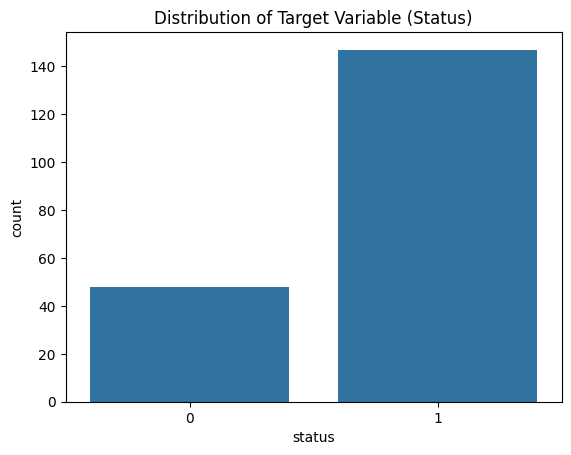

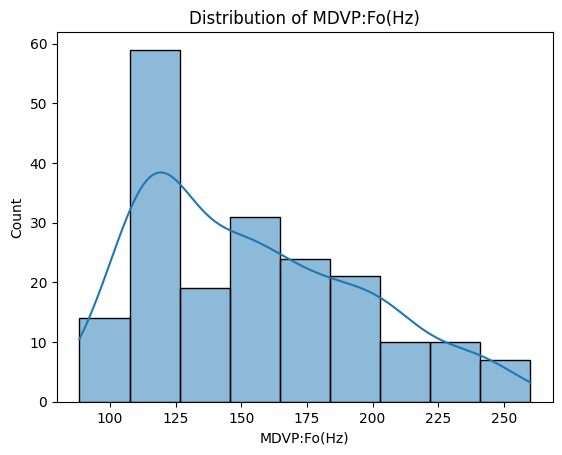

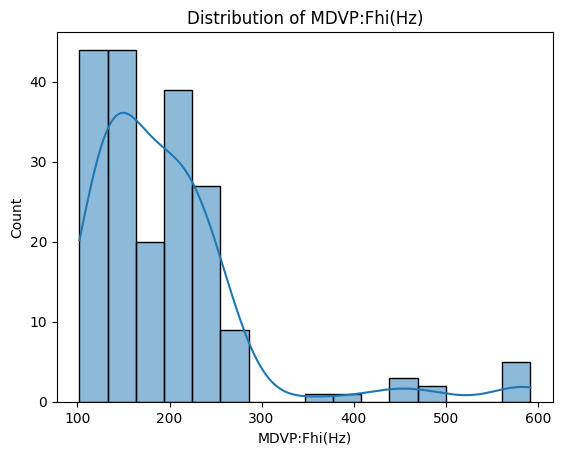

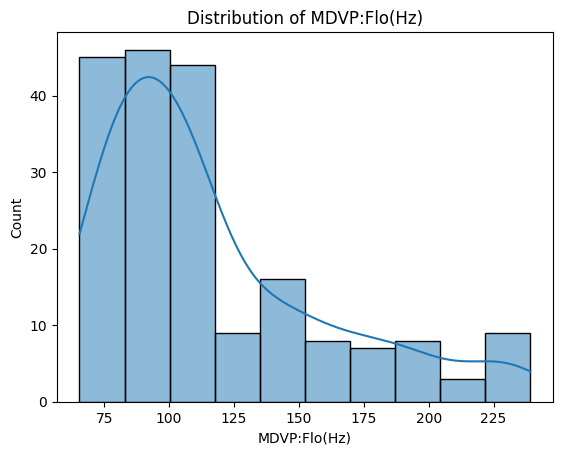

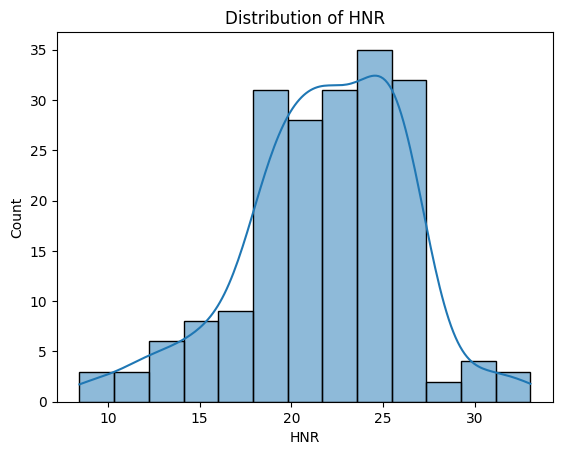

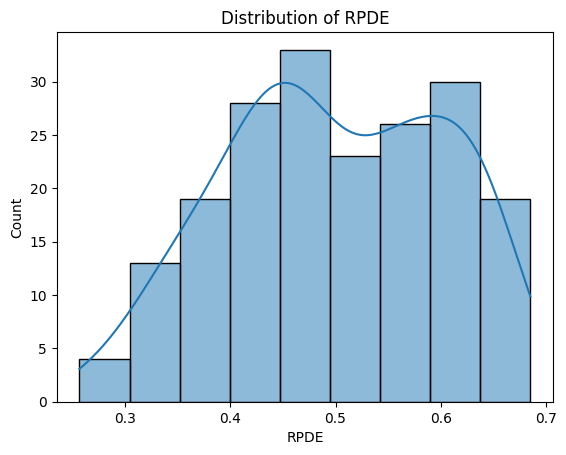

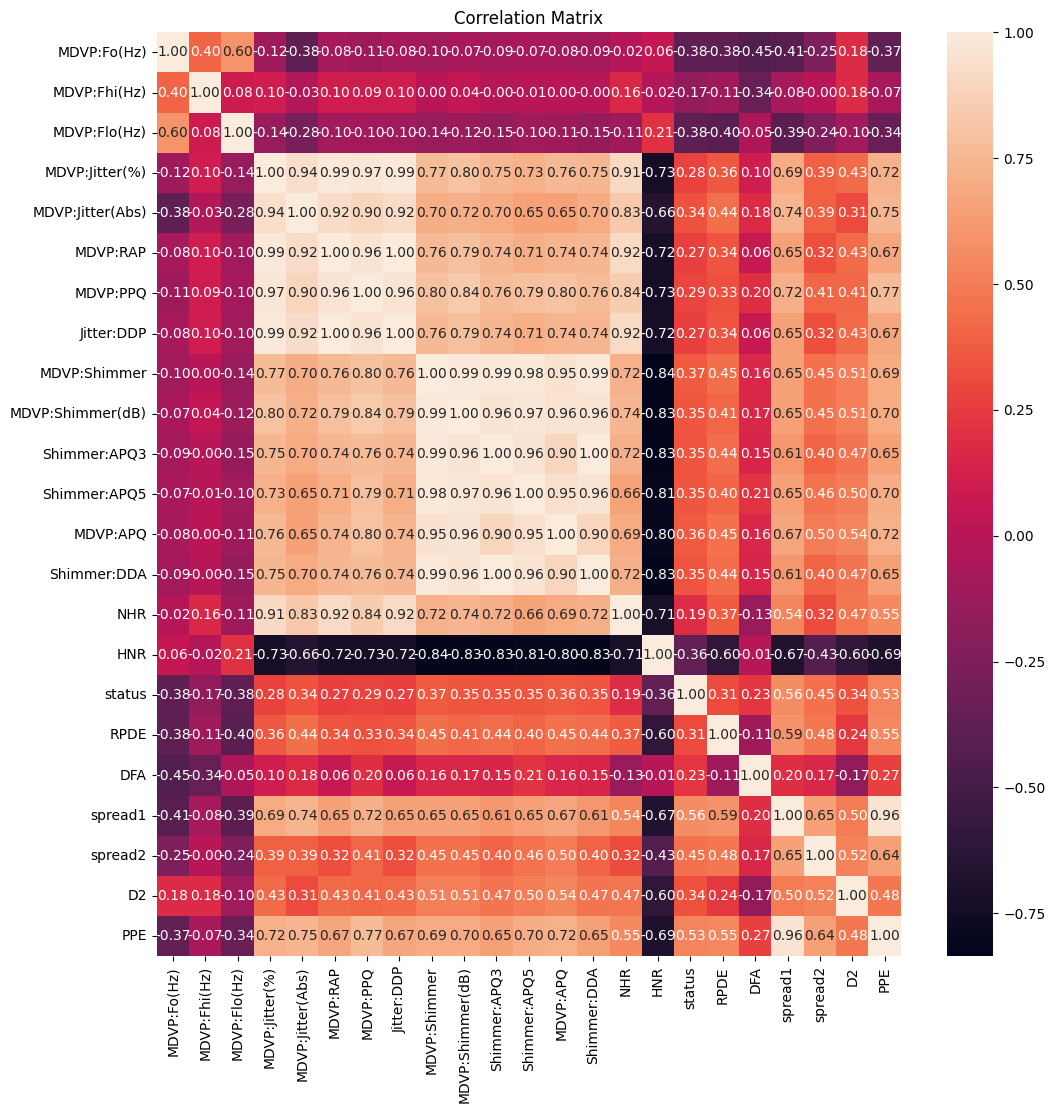

In [35]:
# EDA - Visualizing the distribution of the target variable
sns.countplot(x='status', data=df)
plt.title('Distribution of Target Variable (Status)')
plt.show()

# Visualizing distributions of selected features
selected_features = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'HNR', 'RPDE']
for feature in selected_features:
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

# Correlation matrix
corr_matrix = df.drop('name', axis=1).corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [38]:
# Data preprocessing - Scaling and splitting dataset
features = df.loc[:, df.columns != 'status'].values[:, 1:]
labels = df.loc[:, 'status'].values
scaler = MinMaxScaler((-1, 1))
x = scaler.fit_transform(features)
y = labels
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)


Accuracy: 94.87%

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.94      1.00      0.97        32

    accuracy                           0.95        39
   macro avg       0.97      0.86      0.90        39
weighted avg       0.95      0.95      0.95        39

Confusion Matrix:
 [[ 5  2]
 [ 0 32]]


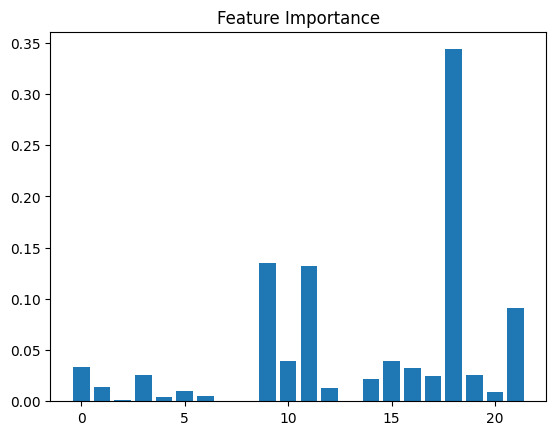

In [39]:
# Training and evaluating the XGBClassifier
xgb_model = XGBClassifier()
xgb_model.fit(x_train, y_train)
y_pred = xgb_model.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature importance visualization
importance = xgb_model.feature_importances_
plt.bar(range(len(importance)), importance)
plt.title('Feature Importance')
plt.show()


In [40]:
# Cross-validation and ROC-AUC evaluation with SMOTE for XGBClassifier
cv = StratifiedKFold(n_splits=5)
roc_auc_scores = []
for train_idx, test_idx in cv.split(x, y):
    x_train_cv, x_test_cv = x[train_idx], x[test_idx]
    y_train_cv, y_test_cv = y[train_idx], y[test_idx]
    
    smote = SMOTE()
    x_train_smote, y_train_smote = smote.fit_resample(x_train_cv, y_train_cv)
    
    xgb_model.fit(x_train_smote, y_train_smote)
    y_pred_cv = xgb_model.predict_proba(x_test_cv)[:, 1]
    roc_auc_scores.append(roc_auc_score(y_test_cv, y_pred_cv))
print("Cross-Validated ROC-AUC Scores:", roc_auc_scores)
print("Average ROC-AUC Score:", np.mean(roc_auc_scores))


Cross-Validated ROC-AUC Scores: [0.825925925925926, 0.6037037037037037, 0.9655172413793104, 0.5241379310344827, 0.8586206896551724]
Average ROC-AUC Score: 0.7555810983397191


In [41]:
# Defining individual models and an ensemble model
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBClassifier": XGBClassifier(),
    "Ensemble Model": VotingClassifier(estimators=[
        ('lr', LogisticRegression()),
        ('svc', SVC(probability=True)),
        ('gb', GradientBoostingClassifier()),
        ('xgb', XGBClassifier())
    ], voting='soft')
}

# Function to evaluate models using cross-validation and SMOTE
def evaluate_model(model, x, y):
    cv_scores = []
    for train_idx, test_idx in cv.split(x, y):
        x_train_cv, x_test_cv = x[train_idx], x[test_idx]
        y_train_cv, y_test_cv = y[train_idx], y[test_idx]
        
        smote = SMOTE()
        x_train_smote, y_train_smote = smote.fit_resample(x_train_cv, y_train_cv)
        
        model.fit(x_train_smote, y_train_smote)
        y_pred_cv = model.predict_proba(x_test_cv)[:, 1]
        cv_scores.append(roc_auc_score(y_test_cv, y_pred_cv))
    return np.mean(cv_scores), np.std(cv_scores)

# Evaluating each model including the ensemble
for name, model in models.items():
    mean_score, std_score = evaluate_model(model, x, y)
    print(f"{name}: ROC-AUC Score: {mean_score:.4f} (+/- {std_score:.4f})")


Logistic Regression: ROC-AUC Score: 0.8119 (+/- 0.1369)
SVM: ROC-AUC Score: 0.7763 (+/- 0.0915)
Random Forest: ROC-AUC Score: 0.7543 (+/- 0.1690)
Gradient Boosting: ROC-AUC Score: 0.7359 (+/- 0.1956)
XGBClassifier: ROC-AUC Score: 0.7463 (+/- 0.1871)
Ensemble Model: ROC-AUC Score: 0.7940 (+/- 0.1402)
